In [1]:
import codecs
import json
import numpy as np
import sklearn

In [2]:
from Scripts.ProcessingEmbeddings import *
import Scripts.utils as utils

In [3]:
#Creating an embeddings object: 400k words, 50 dimensions
glove=Embeddings('Data/glove-wiki-gigaword-300.txt', gensim=False)
#word2vec=Embeddings('Data/word2vec-google-news-300.txt', gensim=False)

Loading Data/glove-wiki-gigaword-300.txt embeddings
vectors shape: (400000, 300), word2idx length: 400000, vocab length: 400000


In [4]:
#Getting the attributes of the embeddings 
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()


In [5]:
#Verifying the attributes: there shouldn't be any null values
np.isnan(vectors).any()

False

In [6]:
#Removing puntuation and numbers from the embeddings
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(
    vectors, word2idx, vocab)


100%|██████████| 400000/400000 [00:00<00:00, 634072.26it/s]


Size of limited vocabulary: 327185


In [7]:
#Checking if vector are normalized
np.apply_along_axis(np.linalg.norm, 1, vectors_cleaned)
#They are not!

array([5.18139682, 5.45449219, 5.91459155, ..., 5.73745479, 6.25541744,
       3.3774816 ])

## Hard-Debias Algorithm

#### Preliminaries

In [8]:
from Scripts.HardDebias import *

In [9]:
#Gender specific vocabulary from Bolukbasi's paper.
gender_specific = []
female_vocab = []
male_vocab = []
with open('./Data/male_word_file.txt') as f:
    male_vocab = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        female_vocab.append(l.strip())

gender_specific = female_vocab+female_vocab

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))


In [10]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets={
    "gender" : [
    ['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
    ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'],['aunt', 'uncle']],
    
    "race":[
		["black", "caucasian", "asian", "hispanic"],
		["african", "caucasian", "asian", "hispanic"],
		["black", "white", "asian", "latino"],
		["africa", "europe", "asia", "mexico"],
		["africa", "america", "china", "latin-america"],
    ]
	}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], [
            "Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], [
            "grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], [
            "wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], [
            "brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman",
                                                        "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], [
            "fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], [
            "gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], [
            "his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"], [
            "men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]],

    "race": [
        ["black", "caucasian", "asian"],
      	["african", "caucasian", "asian"],
      	["black", "white", "asian"],
      	["africa", "america", "asia"],
      	["africa", "america", "china"],
      	["africa", "europe", "asia"]
    ]}

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.


In [11]:
#Lists of names for validation
#Adapted from Speer's tutorial on racism in sentiment analysis. http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
names_ethnicity = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Jamal', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
   
}
#Following Bolukbasi et al. Implementing notebook: https://github.com/tolga-b/debiaswe/blob/master/tutorial_example1.ipynb
names = ["Emily", "Aisha", "Anne", "Keisha", "Jill", "Tamika", "Allison", "Lakisha", "Laurie", "Tanisha", "Sarah",
         "Latoya", "Meredith", "Kenya", "Carrie", "Latonya", "Kristen", "Ebony", "Todd", "Rasheed", "Neil", "Tremayne",
         "Geoffrey", "Kareem", "Brett", "Darnell", "Brendan", "Tyrone", "Greg", "Hakim", "Matthew", "Jamal", "Jay",
         "Leroy", "Brad", "Jermaine"]
#names_group1 = [names[2 * i] for i in range(len(names) // 2)]
#names_group2 = [names[2 * i + 1] for i in range(len(names) // 2)]



In [12]:
#Preparing the definite sets for debiasing
def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])

In [13]:
deb_vect_gender, deb_vocab_gender, deb_word2idx_gender, deb_dict_gender = hard_debias(vectors,
                                                                                      dict_vectors,
                                                                                      word2idx_cleaned,
                                                                                      vocab_cleaned,
                                                                                      equalizing_lists['gender'],
                                                                                      def_set_gender,
                                                                                      1,
                                                                                      normalize_dir=False,
                                                                                      normalize=None,
                                                                                      centralizing=True)


Length of vectors set: 22
Running PCA with 1 components


## Intersectionality study
Bias is not binary nor one dimensional, if clusters are shuffled, what is the effect of the shuffling on other social classes? Is there a way to measure it?

In [14]:
#Find the words in the female_vocab that are also in the embeddings
female_words_emb=[word for word in female_vocab if word in dict_vec_cleaned.keys()]
male_words_emb = [word for word in male_vocab if word in dict_vec_cleaned.keys()]

print('Number of female words in embeddings:', len(female_words_emb))
print('Number of male words in embeddings:', len(male_words_emb))


Number of female words in embeddings: 195
Number of male words in embeddings: 204


In [15]:
#getting the gender directions
gen_dir_centralized=identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=True)
#flattening them
gen_dir_centralized_flat=np.squeeze(gen_dir_centralized)


Length of vectors set: 22
Running PCA with 1 components


In [16]:
from Scripts.Evaluation import compute_gender_simple_bias, compute_similarity_to_bias_direction
similarity_centralized=compute_similarity_to_bias_direction(dict_vec_cleaned, gen_dir_centralized_flat)
simple_gender_bias=compute_gender_simple_bias(dict_vec_cleaned, dict_vec_cleaned['he'], dict_vec_cleaned['she'])
deb_similarity_centralized=compute_similarity_to_bias_direction(deb_dict_gender, gen_dir_centralized_flat)
deb_simple_gender_bias=compute_gender_simple_bias(deb_dict_gender, deb_dict_gender['he'], deb_dict_gender['she'])

In [17]:
#Find the words in the female_vocab that are also in the embeddings
names_white_emb = [
    word.lower() for word in names_ethnicity['White'] if word.lower() in dict_vec_cleaned.keys()]
names_black_emb = [
    word.lower() for word in names_ethnicity['Black'] if word.lower() in dict_vec_cleaned.keys()]

names_hispanic_emb = [
    word.lower() for word in names_ethnicity['Hispanic'] if word.lower() in dict_vec_cleaned.keys()]


print('Number of white names in embeddings:', len(names_white_emb))
print('Number of black names in embeddings:', len(names_black_emb))
print('Number of hispanic names in embeddings:', len(names_hispanic_emb))



Number of white names in embeddings: 48
Number of black names in embeddings: 39
Number of hispanic names in embeddings: 30


In [18]:
import pandas as pd
#get a dataframe with the bias scores of the female_words_emb and male_words_emb in the similarity, similarity_centralized and simple_gender_bias


def get_df_bias_scores(word_list, similarity_centralized, simple_bias_score):
    scores = {}
    for word in word_list:
        scores[word] = {"centralized_similarity_score": (similarity_centralized[word]),
                        "simple_bias_score": simple_bias_score[word]}
    df = pd.DataFrame.from_dict(scores, orient='index')
    return df


In [19]:
df_names_white=get_df_bias_scores(names_white_emb, similarity_centralized,simple_gender_bias)
df_names_black=get_df_bias_scores(names_black_emb, similarity_centralized,simple_gender_bias)
df_names_hispanic=get_df_bias_scores(names_hispanic_emb, similarity_centralized,simple_gender_bias)

#now the dataframe for the debiased embeddings
df_names_white_deb=get_df_bias_scores(names_white_emb, deb_similarity_centralized,deb_simple_gender_bias)
df_names_black_deb = get_df_bias_scores(names_black_emb, deb_similarity_centralized,deb_simple_gender_bias)
df_names_hispanic_deb = get_df_bias_scores(
    names_hispanic_emb, deb_similarity_centralized, deb_simple_gender_bias)

#merging the dataframes
df_names_white_merged=pd.merge(df_names_white, df_names_white_deb, left_index=True, right_index=True, suffixes=('_orig', '_deb'))
df_names_black_merged=pd.merge(df_names_black, df_names_black_deb, left_index=True, right_index=True, suffixes=('_orig', '_deb'))
df_names_hispanic_merged=pd.merge(df_names_hispanic, df_names_hispanic_deb, left_index=True, right_index=True, suffixes=('_orig', '_deb'))


df_names_white_merged


,centralized_similarity_score_orig,simple_bias_score_orig,centralized_similarity_score_deb,simple_bias_score_deb
adam,-0.185898,-0.094373,-1.402362e-07,1.493309e-09
chip,-0.044571,-0.020428,-7.884275e-08,5.179480e-09
harry,-0.071752,0.006493,-1.990548e-07,3.913110e-09
josh,-0.096062,-0.014186,-1.646718e-07,6.410092e-09
roger,-0.231225,-0.110803,-1.328456e-07,7.128524e-09
alan,-0.129366,-0.048589,-9.871449e-08,5.221612e-09
frank,-0.176201,-0.068455,-8.353230e-09,1.151710e-09
ian,-0.137793,-0.049633,-2.072702e-08,1.013679e-08
justin,-0.122327,-0.019525,-1.249698e-07,-5.482692e-09
ryan,-0.077191,-0.017689,-1.789196e-07,1.025711e-08


In [20]:
# To do: plot the barplots of similarity and simple bias scores faceted for original and debiased embeddings
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
#fig= make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(
    x=df_names_white_merged.index,
    y=df_names_white_merged['centralized_similarity_score_orig'],
    name='Original',
    marker_color='indianred'),
    #secondary_y=False
)
fig.add_trace(go.Bar(x=df_names_white_merged.index,
                     y=df_names_white_merged['simple_bias_score_orig'],
                     name='Original_ simple',
                     marker_color='green'),
                     #secondary_y=False
                     )


fig1 = go.Figure()
fig1.add_trace(go.Bar(x=df_names_white_merged.index,
                        y=df_names_white_merged['simple_bias_score_deb'],
                        name='Debiased_ simple',
                        marker_color='lightgreen'), 
                        #secondary_y=True
                        )


fig1.add_trace(go.Bar(
    x=df_names_white_merged.index,
    y=df_names_white_merged['centralized_similarity_score_deb'],
    name='Debiased',
    marker_color='lightsalmon'),
    #secondary_y=True
)

fig.show()
fig1.show()

In [21]:
#plot a bar plot of the top 20 most biased words with all the scores of the three methods
import plotly_express as px


def plot_top_biased_words(df, n_words=20):
    df_top = df.head(n_words)
    #remove the simple_bias_score column
    #df_top = df_top.drop(columns=['simple_bias_score'])
    df_top = df_top.reset_index()
    df_top = df_top.rename(columns={'index': 'word'})
    df_top = df_top.melt(
        id_vars=['word'], var_name='score_type', value_name='score')
    fig = px.bar(df_top, x="score", y="word",
                 color="score_type", barmode="group", orientation='h',
                 height=1000, width=800, title="Top biased words")
   
    
    fig.show()


plot_top_biased_words(df_names_white, n_words=50)
plot_top_biased_words(df_names_black, n_words=50)
plot_top_biased_words(df_names_hispanic, n_words=50)


1.2 Neutral words associated with ethnic names

In [22]:
from Scripts.Evaluation import *

In [23]:
def get_frequency_neutral_words(names, neutral_words, dict_vect_debiased, vocab_debiased, vectors_debiased, w2i_debiased, neighbours_num=50):
    """"
    Function to get the frequency of the original neighbors among the 50 nearest neighbors of selected words
    :param list_words: list of words to compute the bias for
    :param list_neigh: list of the neighbors for each word of the dictionary k_neigh
    :param dict_vect_debiased: dictionary of words and their embeddings
    :param vocab_debiased: list of words in the vocabulary
    :param vectors_debiased: list of embeddings
    :param w2i_debiased: dictionary of words and their indices
    :param neighbours_num: number of neighbors to find
    :return: list of the frequency of the original neighbors among the 50 nearest neighbors of selected words
    """
    scores = []
    for word in tqdm(set(names)):
        which_words=[]
        #get the top 50 neighbors of the word
        _, top = get_topK_neighbors(word, dict_vect_debiased, vocab_debiased, vectors_debiased, w2i_debiased,
                                    k=neighbours_num)

        count = 0
        #check if the original neighbors are in the top 50
        for t in top:
            if t in set(neutral_words):
                print(t)
                count += 1
                which_words.append(t)

        scores.append([word, which_words, count, count/neighbours_num])
        #print(top)
    return scores


In [24]:
neutral_words

['manager',
 'executive',
 'doctor',
 'lawyer',
 'programmer',
 'scientist',
 'soldier',
 'supervisor',
 'rancher',
 'janitor',
 'firefighter',
 'officer',
 'secretary',
 'nurse',
 'clerk',
 'artist',
 'homemaker',
 'dancer',
 'singer',
 'librarian',
 'maid',
 'hairdresser',
 'stylist',
 'receptionist',
 'counselor',
 'leader',
 'farmer',
 'engineer',
 'laborer',
 'teacher',
 'slave',
 'musician',
 'runner',
 'criminal',
 'homeless',
 'greedy',
 'cheap',
 'hairy',
 'liberal',
 'judgemental',
 'conservative',
 'familial',
 'violent',
 'terrorist',
 'dirty',
 'uneducated',
 'educated']

In [25]:
#frequencies of neighbors
neutral_on_white=get_frequency_neutral_words(
    names_white_emb, neutral_words, dict_vectors, vocab_cleaned, vectors_cleaned, word2idx_cleaned, neighbours_num=100)

neutral_on_white_deb = get_frequency_neutral_words(
    names_white_emb, neutral_words, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=100)


 50%|█████     | 24/48 [00:42<00:42,  1.77s/it]

singer


 58%|█████▊    | 28/48 [00:49<00:35,  1.77s/it]

executive


 81%|████████▏ | 39/48 [01:08<00:15,  1.75s/it]

executive
manager


 83%|████████▎ | 40/48 [01:10<00:14,  1.75s/it]

manager


  4%|▍         | 2/48 [00:03<01:15,  1.64s/it]

counselor


 25%|██▌       | 12/48 [00:18<00:56,  1.56s/it]

counselor


 31%|███▏      | 15/48 [00:23<00:51,  1.56s/it]

liberal


 38%|███▊      | 18/48 [00:28<00:47,  1.57s/it]

homeless


 40%|███▉      | 19/48 [00:29<00:45,  1.57s/it]

secretary


 46%|████▌     | 22/48 [00:34<00:40,  1.57s/it]

musician


 48%|████▊     | 23/48 [00:36<00:39,  1.57s/it]

scientist
secretary


 81%|████████▏ | 39/48 [01:01<00:14,  1.57s/it]

executive


 83%|████████▎ | 40/48 [01:02<00:12,  1.57s/it]

dirty


 85%|████████▌ | 41/48 [01:04<00:11,  1.57s/it]

homeless


100%|██████████| 48/48 [01:15<00:00,  1.57s/it]

executive


In [26]:
neutral_on_black = get_frequency_neutral_words(
    names_black_emb, neutral_words, dict_vectors, vocab_cleaned, vectors_cleaned, word2idx_cleaned, neighbours_num=100)


neutral_on_black_deb = get_frequency_neutral_words(
    names_black_emb, neutral_words, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=100)


 74%|███████▍  | 29/39 [00:45<00:15,  1.57s/it]

counselor


100%|██████████| 39/39 [01:01<00:00,  1.57s/it]


In [ ]:
neutral_on_black_deb


[['darnell', [], 0, 0.0],
 ['shereen', [], 0, 0.0],
 ['lerone', [], 0, 0.0],
 ['leroy', [], 0, 0.0],
 ['latisha', [], 0, 0.0],
 ['tyrone', [], 0, 0.0],
 ['jamal', [], 0, 0.0],
 ['jamel', [], 0, 0.0],
 ['latonya', [], 0, 0.0],
 ['ebony', [], 0, 0.0],
 ['tawanda', [], 0, 0.0],
 ['lamont', [], 0, 0.0],
 ['yvette', [], 0, 0.0],
 ['nichelle', [], 0, 0.0],
 ['malik', [], 0, 0.0],
 ['tanisha', [], 0, 0.0],
 ['latoya', [], 0, 0.0],
 ['lamar', [], 0, 0.0],
 ['shaniqua', [], 0, 0.0],
 ['lakisha', [], 0, 0.0],
 ['jasmine', [], 0, 0.0],
 ['tia', [], 0, 0.0],
 ['tyree', [], 0, 0.0],
 ['torrance', [], 0, 0.0],
 ['deion', [], 0, 0.0],
 ['marcellus', [], 0, 0.0],
 ['temeka', [], 0, 0.0],
 ['malika', [], 0, 0.0],
 ['jerome', ['counselor'], 1, 0.01],
 ['alphonse', [], 0, 0.0],
 ['rashaun', [], 0, 0.0],
 ['theo', [], 0, 0.0],
 ['yolanda', [], 0, 0.0],
 ['terryl', [], 0, 0.0],
 ['alonzo', [], 0, 0.0],
 ['wardell', [], 0, 0.0],
 ['lionel', [], 0, 0.0],
 ['terrence', [], 0, 0.0],
 ['lavon', [], 0, 0.0]]

In [28]:
neutral_on_hispanic = get_frequency_neutral_words(
    names_hispanic_emb, neutral_words, dict_vectors, vocab_cleaned, vectors_cleaned, word2idx_cleaned, neighbours_num=100)

neutral_on_hispanic_deb = get_frequency_neutral_words(
    names_hispanic_emb, neutral_words, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=100)


 67%|██████▋   | 20/30 [00:36<00:18,  1.84s/it]


KeyboardInterrupt: 

In [ ]:

#df2 = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])
#merge the two dataframes on the word column
#merge df and df average on word
#df_merged_punct = df2.merge(df_average, on='word')
#df=pd.concat([df,df_merged], axis=1, keys='words')


In [29]:
#WEAT
# Auxiliary functions for experiments by Caliskan et al.

import scipy
import scipy.misc as misc
import itertools
from Scripts.utils import *


def similarity(word_dict, word1, word2):

    
    vec1 = word_dict[word1]
    vec2 = word_dict[word2]

    return cosine_similarity(vec1, vec2)

def s_word(word_dict,w, A, B,all_s_words):

    if w in all_s_words:
        return all_s_words[w]

    mean_a = []
    mean_b = []

    for a in A:
        mean_a.append(similarity(word_dict,w, a))
    for b in B:
        mean_b.append(similarity(word_dict,w, b))

    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))

    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(word_dict,X, Y, A, B,all_s_words):

    total = 0
    for x in X:
        total += s_word(word_dict,x, A, B,all_s_words)
    for y in Y:
        total -= s_word(word_dict,y, A, B, all_s_words)

    return total


def p_value_exhust(word_dict,X, Y, A, B):

    if len(X) > 20:
        print('might take too long, use sampled version: p_value')
        return

    assert(len(X) == len(Y))

    all_s_words = {}
    s_orig = s_group(word_dict,X, Y, A, B, all_s_words)

    union = set(X+Y)
    subset_size = len(union)/2

    larger = 0
    total = 0
    for subset in tqdm(set(itertools.combinations(union, int(subset_size)))):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        if s_group(word_dict,Xi, Yi, A, B, all_s_words) > s_orig:
            larger += 1
    print('num of samples', total)
    #print(all_s_words)
    return larger/float(total)


def p_value_sample(word_dict,X, Y, A, B):

    np.random.seed(42)
    
    all_s_words = {}

    assert(len(X) == len(Y))
    length = len(X)

    s_orig = s_group(word_dict, X, Y, A, B, all_s_words)

    num_of_samples = min(1000000, int(
        scipy.special.comb(length*2, length)*100))
    print('num of samples', num_of_samples)
    larger = 0
    for i in range(num_of_samples):
        permute = np.random.permutation(X+Y)
        Xi = permute[:length]
        Yi = permute[length:]
        if s_group(word_dict,Xi, Yi, A, B, all_s_words) > s_orig:
            larger += 1

    return larger/float(num_of_samples)


In [113]:

def effect_size(X, Y, A, B,  wv, w2i, vocab):

    assert(len(X) == len(Y))
    assert(len(A) == len(B))

    norm_x = []
    norm_y = []

    for x in X:
        norm_x.append(association_diff(x, A, B, wv, w2i))
    for y in Y:
        norm_y.append(association_diff(y, A, B, wv, w2i))

    std = np.std(norm_x+norm_y, ddof=1)
    norm_x = sum(norm_x) / float(len(norm_x))
    norm_y = sum(norm_y) / float(len(norm_y))

    return (norm_x-norm_y)/std


In [30]:
# Experiment 1

A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']
C = ['executive', 'management', 'professional',
     'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family',
     'cousins', 'marriage', 'wedding', 'relatives']

print(p_value_exhust(dict_vec_cleaned,A, B, C, D))


# Experiment 2

E = ['math', 'algebra', 'geometry', 'calculus',
     'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature',
     'novel', 'symphony', 'drama', 'sculpture']

print(p_value_exhust(dict_vec_cleaned,A, B, E, F))

low_wage_occupations=['janitor', 'maid', 'clerk', 'assistant', 'laborer', 'operator', 'helper', 'fireman', 'guard', 'carpenter', 'electrician', 'plumber', 'mechanic', 'cook', 'waiter', 'porter', 'cleaner', 'tailor', 'mechanic', 'hairdresser', 'janitor', 'maid', 'clerk', 'assistant', 'laborer', 'operator', 'helper', 'fireman', 'guard', 'carpenter', 'electrician', 'plumber', 'mechanic', 'cook', 'waiter', 'porter', 'cleaner', 'tailor', 'mechanic', 'hairdresser', 'janitor', 'maid', 'clerk', 'assistant', 'laborer', 'operator', 'helper', 'fireman', 'guard', 'carpenter', 'electrician', 'plumber', 'mechanic', 'cook', 'waiter', 'porter', 'cleaner', 'tailor', 'mechanic', 'hairdresser', 'janitor', 'maid', 'clerk', 'assistant', 'laborer', 'operator', 'helper', 'fireman', 'guard', 'carpenter', 'electrician', 'plumber', 'mechanic', 'cook', 'waiter', 'porter', 'cleaner', 'tailor', 'mechanic', 'hairdresser', 'janitor', 'maid', 'clerk', 'assistant', 'laborer', 'operator', 'helper', 'fireman', 'guard', 'carpenter', 'electrician', 'plumber', 'mechanic', 'cook', 'waiter', 'porter', 'cleaner', 'tailor', 'mechanic', 'hairdresser', 'janitor', 'maid', 'clerk', 'assistant', 'laborer', 'operator', 'helper', 'fireman', 'guard', 'carpenter', 'electrician', 'plumber', 'mechanic', 'cook', 'waiter', 'porter', 'cleaner', 'tailor', 'mechanic', 'hairdresser', 'janitor', 'maid', 'clerk', 'assistant', 'laborer', 'operator', 'helper', 'fireman', 'guard',]

# Experiment 3

G = ['science', 'technology', 'physics', 'chemistry',
     'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance',
     'literature', 'novel', 'symphony', 'drama']

print(p_value_exhust(dict_vec_cleaned,A, B, G, H))

pleasant = ["caress", "freedom", "health", "love", "peace", "cheer", "friend", "heaven", "loyal", "pleasure", "diamond", "gentle",
            "honest", "lucky", "rainbow", "diploma", "gift", "honor", "miracle", "sunrise", "family", "happy", "laughter", "paradise", "vacation"]

unpleasant=["abuse","crash","filth","murder","sickness","accident","death","grief","poison","stink","assault","disaster","hatred","pollute","tragedy","bomb","divorce","jail","poverty","ugly","cancer","evil","kill","rotten","vomit"]


print(p_value_exhust(dict_vec_cleaned,A, B, pleasant, unpleasant))


music=["bagpipe","cello","guitar","lute","trombone","banjo","clarinet","harmonica","mandolin", "trumpet","bassoon","drum","harp","oboe","tuba","bell","fiddle","harpsichord","piano","viola","bongo","flute","horn","saxophone","violin","voice"]
guns=["arrow","club","gun","missile","spear","axe","dagger","harpoon","pistol","sword","blade","dynamite","hatchet","rifle","tank","bomb","firearm","knife","shotgun","teargas","cannon","grenade","mace","slingshot","whip"]


print(p_value_exhust(dict_vec_cleaned,A, B, guns, music))

100%|██████████| 12870/12870 [00:00<00:00, 222945.55it/s]


num of samples 12870
0.0


100%|██████████| 12870/12870 [00:00<00:00, 239652.17it/s]


num of samples 12870
0.0005439005439005439


100%|██████████| 12870/12870 [00:00<00:00, 238122.45it/s]


num of samples 12870
0.0


100%|██████████| 12870/12870 [00:00<00:00, 241083.17it/s]


num of samples 12870
0.34444444444444444


100%|██████████| 12870/12870 [00:00<00:00, 240813.22it/s]

num of samples 12870
0.31445221445221444


In [79]:
print(p_value_exhust(deb_dict_gender,A, B, C, D))
print(p_value_exhust(deb_dict_gender, A, B, E, F))
print(p_value_exhust(deb_dict_gender, A, B, G, H))

print(p_value_exhust(deb_dict_gender,A, B, pleasant, unpleasant))
print(p_value_exhust(deb_dict_gender,A, B, guns, music))

100%|██████████| 12870/12870 [00:00<00:00, 217244.49it/s]


num of samples 12870
0.002874902874902875


100%|██████████| 12870/12870 [00:00<00:00, 240831.49it/s]


num of samples 12870
0.7176379176379176


100%|██████████| 12870/12870 [00:00<00:00, 234544.68it/s]


num of samples 12870
0.671095571095571


100%|██████████| 12870/12870 [00:00<00:00, 242012.71it/s]


num of samples 12870
0.662004662004662


100%|██████████| 12870/12870 [00:00<00:00, 239972.85it/s]

num of samples 12870
0.021056721056721055


In [28]:
male_black_names=names_black_emb[:8]
male_white_names=names_white_emb[:8]
female_black_names=names_black_emb[-8:]
female_white_names=names_white_emb[-8:]
neutral_test=neutral_words[-9:-1]

In [29]:
#Black and white names with career and family
print('Black and white male names with career and family')
print(p_value_exhust(dict_vec_cleaned,male_white_names, male_black_names, C, D))
print(p_value_sample(dict_vec_cleaned,male_white_names, male_black_names, C, D))
print(p_value_exhust(deb_dict_gender,male_white_names, male_black_names, C, D))

#Black and white names with math and arts
print('Black and white male names with math and arts')
print(p_value_exhust(dict_vec_cleaned,male_white_names, male_black_names, E, F))
print(p_value_exhust(deb_dict_gender,male_white_names, male_black_names, E, F))

#Black and white names with science and arts
print('Black and white male names with science and arts')
print(p_value_exhust(dict_vec_cleaned,male_white_names, male_black_names, G,H))
print(p_value_exhust(deb_dict_gender, male_white_names, male_black_names, G, H))

#Black and white names with career and values (liberality, education, violence)
print('Black and white male names with career and values (liberality, education, violence)')
print(p_value_exhust(dict_vec_cleaned,male_white_names, male_black_names, C, neutral_test))
print(p_value_exhust(deb_dict_gender, male_white_names,
      male_black_names, C, neutral_test))

#Black and white names with career and values (liberality, education, violence)
print('Black and white male names with career and low_wage_occupations')
print(p_value_exhust(dict_vec_cleaned, male_white_names,
      male_black_names, C, low_wage_occupations))
print(p_value_exhust(deb_dict_gender, male_white_names,
      male_black_names, C, low_wage_occupations))

#Black and white names with career and values (liberality, education, violence)
print('Black and white male names with pleasant and unpleasant words')
print(p_value_exhust(dict_vec_cleaned,male_white_names, male_black_names, pleasant, unpleasant))
print(p_value_exhust(deb_dict_gender,male_white_names, male_black_names, pleasant, unpleasant))

Black and white male names with career and family


100%|██████████| 12870/12870 [00:00<00:00, 221084.65it/s]

num of samples 12870
0.13263403263403264
num of samples 1000000


0.132708


100%|██████████| 12870/12870 [00:00<00:00, 235476.76it/s]


num of samples 12870
0.44638694638694637
Black and white male names with math and arts


100%|██████████| 12870/12870 [00:00<00:00, 222630.17it/s]


num of samples 12870
0.9848484848484849


100%|██████████| 12870/12870 [00:00<00:00, 226984.16it/s]


num of samples 12870
0.9828282828282828
Black and white male names with science and arts


100%|██████████| 12870/12870 [00:00<00:00, 230310.74it/s]


num of samples 12870
0.5732711732711733


100%|██████████| 12870/12870 [00:00<00:00, 229216.40it/s]


num of samples 12870
0.8450660450660451
Black and white male names with career and values (liberality, education, violence)


100%|██████████| 12870/12870 [00:00<00:00, 210497.00it/s]


num of samples 12870
7.77000777000777e-05


100%|██████████| 12870/12870 [00:00<00:00, 228450.06it/s]


num of samples 12870
0.06557886557886558
Black and white male names with career and low_wage_occupations


100%|██████████| 12870/12870 [00:00<00:00, 228515.82it/s]


num of samples 12870
0.0


100%|██████████| 12870/12870 [00:00<00:00, 228705.58it/s]


num of samples 12870
0.008158508158508158
Black and white male names with pleasant and unpleasant words


100%|██████████| 12870/12870 [00:00<00:00, 226265.83it/s]


num of samples 12870
0.002874902874902875


100%|██████████| 12870/12870 [00:00<00:00, 229313.78it/s]

num of samples 12870
0.1972027972027972


In [30]:
#Black and white names with career and values (liberality, education, violence)
print('Black and white male names with pleasant and unpleasant words')
print(p_value_exhust(dict_vec_cleaned,male_white_names, male_black_names, music, guns))
print(p_value_exhust(deb_dict_gender,male_white_names, male_black_names, music, guns))

Black and white male names with pleasant and unpleasant words


100%|██████████| 12870/12870 [00:00<00:00, 234315.61it/s]


num of samples 12870
0.7242424242424242


100%|██████████| 12870/12870 [00:00<00:00, 230948.26it/s]

num of samples 12870
0.978010878010878


In [118]:
print('Black and white female names with career and family')
print(p_value_exhust(dict_vec_cleaned,female_white_names, female_black_names, C, D))
print(p_value_exhust(deb_dict_gender,female_white_names, female_black_names, C, D))

#Black and white names with math and arts
print('Black and white female names with math and arts')
print(p_value_exhust(dict_vec_cleaned,female_white_names, female_black_names, E, F))
print(p_value_exhust(deb_dict_gender,female_white_names, female_black_names, E, F))

#Black and white names with science and arts
print('Black and white female names with science and arts')
print(p_value_exhust(dict_vec_cleaned,female_white_names, female_black_names, G,H))
print(p_value_exhust(deb_dict_gender, female_white_names, female_black_names, G, H))

#Black and white names with career and values (liberality, education, violence)
print('Black and white female names with career and values (liberality, education, violence)')
print(p_value_exhust(dict_vec_cleaned,female_white_names, female_black_names, C, neutral_test))
print(p_value_exhust(deb_dict_gender, female_white_names,
      female_black_names, C, neutral_test))


print('Black and white female names with pleasant and unpleasant words')
print(p_value_exhust(dict_vec_cleaned, female_white_names,
      female_black_names, pleasant,unpleasant))
print(p_value_exhust(deb_dict_gender, female_white_names,
      female_black_names, pleasant, unpleasant))


Black and white female names with career and family


100%|██████████| 12870/12870 [00:00<00:00, 227076.78it/s]


num of samples 12870
0.7837606837606838


100%|██████████| 12870/12870 [00:00<00:00, 232570.14it/s]


num of samples 12870
0.01724941724941725
Black and white female names with math and arts


100%|██████████| 12870/12870 [00:00<00:00, 235119.83it/s]


num of samples 12870
0.9988344988344988


100%|██████████| 12870/12870 [00:00<00:00, 235091.16it/s]


num of samples 12870
0.9642579642579643
Black and white female names with science and arts


100%|██████████| 12870/12870 [00:00<00:00, 229313.78it/s]


num of samples 12870
0.9918414918414918


100%|██████████| 12870/12870 [00:00<00:00, 237165.18it/s]


num of samples 12870
0.8168609168609169
Black and white female names with career and values (liberality, education, violence)


100%|██████████| 12870/12870 [00:00<00:00, 233886.16it/s]


num of samples 12870
0.030691530691530692


100%|██████████| 12870/12870 [00:00<00:00, 227997.52it/s]


num of samples 12870
0.020590520590520592
Black and white female names with pleasant and unpleasant words


100%|██████████| 12870/12870 [00:00<00:00, 230553.71it/s]


num of samples 12870
0.002097902097902098


100%|██████████| 12870/12870 [00:00<00:00, 233584.57it/s]

num of samples 12870
0.2236208236208236


In [31]:
print('Black and white female names with pleasant and unpleasant words')
print(p_value_exhust(dict_vec_cleaned, female_white_names,
      female_black_names, music, guns))
print(p_value_exhust(deb_dict_gender, female_white_names,
      female_black_names, music, guns))


Black and white female names with pleasant and unpleasant words


100%|██████████| 12870/12870 [00:00<00:00, 229526.34it/s]


num of samples 12870
0.9226107226107226


100%|██████████| 12870/12870 [00:00<00:00, 235296.11it/s]

num of samples 12870
0.9789432789432789


In [119]:
print('males vs female names with career and family')
print(p_value_sample(dict_vec_cleaned,male_black_names+male_white_names, female_white_names+female_black_names, C, D))
print(p_value_sample(deb_dict_gender,male_black_names+male_white_names, female_white_names+female_black_names, C, D))

#Black and white names with math and arts
print('Black and white female names with math and arts')
print(p_value_sample(dict_vec_cleaned, male_black_names +
      male_white_names, female_white_names+female_black_names, E, F))
print(p_value_sample(deb_dict_gender,male_black_names+male_white_names, female_white_names+female_black_names, E, F))

#Black and white names with science and arts
print('Black and white female names with science and arts')
print(p_value_sample(dict_vec_cleaned, male_black_names +
      male_white_names, female_white_names+female_black_names, G, H))
print(p_value_sample(deb_dict_gender, male_black_names +
      male_white_names, female_white_names+female_black_names, G, H))

#Black and white names with career and values (liberality, education, violence)
print('Black and white female names with career and values (liberality, education, violence)')
print(p_value_sample(dict_vec_cleaned,male_black_names+male_white_names, female_white_names+female_black_names, C, neutral_words[-17:-1]))
print(p_value_sample(deb_dict_gender,male_black_names+male_white_names, female_white_names+female_black_names, C, neutral_words[-17:-1]))

print('Black and white female names with pleasant and unpleasant words')
print(p_value_sample(dict_vec_cleaned,male_black_names+male_white_names, female_white_names+female_black_names, pleasant, unpleasant))
print(p_value_sample(deb_dict_gender,male_black_names+male_white_names, female_white_names+female_black_names, pleasant, unpleasant))

males vs female names with career and family
num of samples 1000000
1e-05
num of samples 1000000
0.029729
Black and white female names with math and arts
num of samples 1000000
0.611626
num of samples 1000000
0.977509
Black and white female names with science and arts
num of samples 1000000
0.346551
num of samples 1000000
0.391843
Black and white female names with career and values (liberality, education, violence)
num of samples 1000000
0.011032
num of samples 1000000
0.090137
Black and white female names with pleasant and unpleasant words
num of samples 1000000
0.222511
num of samples 1000000
0.769125


In [37]:
print('Black and white female names with pleasant and unpleasant words')
print(p_value_sample(dict_vec_cleaned,male_black_names+male_white_names, female_white_names+female_black_names, guns, music))
print(p_value_sample(deb_dict_gender,male_black_names+male_white_names, female_white_names+female_black_names, guns, music))

Black and white female names with pleasant and unpleasant words
num of samples 1000000
0.362065
num of samples 1000000
0.012881


In [120]:
#Black and white names with career and values (liberality, education, violence)
print('Black and white names with career and low wage occupations')
print(p_value_sample(dict_vec_cleaned,male_black_names+male_white_names, female_white_names+female_black_names, C, low_wage_occupations))
print(p_value_sample(deb_dict_gender,male_black_names+male_white_names, female_white_names+female_black_names, C, low_wage_occupations))

Black and white names with career and low wage occupations
num of samples 1000000
0.002291
num of samples 1000000
0.015557


In [123]:
print('Black and white female names with career and family')
print(p_value_exhust(dict_vec_cleaned,male_black_names, female_white_names, C, D))
print(p_value_exhust(deb_dict_gender,male_black_names, female_white_names, C, D))

#Black and white names with math and arts
print('Black and white female names with math and arts')
print(p_value_exhust(dict_vec_cleaned,male_black_names, female_white_names, E, F))
print(p_value_exhust(deb_dict_gender,male_black_names, female_white_names, E, F))

#Black and white names with science and arts
print('Black and white female names with science and arts')
print(p_value_exhust(dict_vec_cleaned,male_black_names, female_white_names, G,H))
print(p_value_exhust(deb_dict_gender, male_black_names, female_white_names, G, H))

#Black and white names with career and values (liberality, education, violence)
print('Black and white female names with career and values (liberality, education, violence)')
print(p_value_exhust(dict_vec_cleaned,male_black_names, female_white_names, C, neutral_test))
print(p_value_exhust(deb_dict_gender,male_black_names, female_white_names, C, neutral_test))

#Black and white names with pleasant and unpleasant words
print('Black and white female names with pleasant and unpleasant words')
print(p_value_exhust(dict_vec_cleaned,male_black_names, female_white_names, unpleasant, pleasant))
print(p_value_exhust(deb_dict_gender,male_black_names, female_white_names, unpleasant, pleasant))

#Black and white names with career and low wage occupations
print('Black and white female names with pleasant and unpleasant words')
print(p_value_exhust(dict_vec_cleaned,male_black_names, female_white_names, C, low_wage_occupations))
print(p_value_exhust(deb_dict_gender,male_black_names, female_white_names, C, low_wage_occupations))

Black and white female names with career and family


100%|██████████| 12870/12870 [00:00<00:00, 228494.54it/s]


num of samples 12870
0.00202020202020202


100%|██████████| 12870/12870 [00:00<00:00, 228954.88it/s]


num of samples 12870
0.34763014763014766
Black and white female names with math and arts


100%|██████████| 12870/12870 [00:00<00:00, 225034.88it/s]


num of samples 12870
0.0016317016317016317


100%|██████████| 12870/12870 [00:00<00:00, 225417.35it/s]


num of samples 12870
0.31033411033411035
Black and white female names with science and arts


100%|██████████| 12870/12870 [00:00<00:00, 230629.56it/s]


num of samples 12870
0.022999222999223


100%|██████████| 12870/12870 [00:00<00:00, 232360.91it/s]


num of samples 12870
0.11810411810411811
Black and white female names with career and values (liberality, education, violence)


100%|██████████| 12870/12870 [00:00<00:00, 229627.88it/s]


num of samples 12870
0.4881118881118881


100%|██████████| 12870/12870 [00:00<00:00, 211871.78it/s]


num of samples 12870
0.5063714063714063
Black and white female names with pleasant and unpleasant words


100%|██████████| 12870/12870 [00:00<00:00, 228276.16it/s]


num of samples 12870
0.01554001554001554


100%|██████████| 12870/12870 [00:00<00:00, 230402.16it/s]


num of samples 12870
0.1041958041958042
Black and white female names with pleasant and unpleasant words


100%|██████████| 12870/12870 [00:00<00:00, 230897.88it/s]


num of samples 12870
0.8462315462315463


100%|██████████| 12870/12870 [00:00<00:00, 224266.38it/s]

num of samples 12870
0.9298368298368298


In [36]:
#Black and white names with career and low wage occupations
print('Black and white female names with pleasant and unpleasant words')
print(p_value_exhust(dict_vec_cleaned,male_black_names, female_white_names, guns, music))
print(p_value_exhust(deb_dict_gender,male_black_names, female_white_names, guns, music))

Black and white female names with pleasant and unpleasant words


100%|██████████| 12870/12870 [00:00<00:00, 216918.86it/s]


num of samples 12870
0.8160839160839161


100%|██████████| 12870/12870 [00:00<00:00, 234226.14it/s]

num of samples 12870
0.6232323232323232


In [122]:
print('Black and white female names with career and family')
print(p_value_exhust(dict_vec_cleaned,male_white_names, female_black_names, C, D))
print(p_value_exhust(deb_dict_gender,male_white_names, female_black_names, C, D))

#Black and white names with math and arts
print('Black and white female names with math and arts')
print(p_value_exhust(dict_vec_cleaned,male_white_names, female_black_names, E, F))
print(p_value_exhust(deb_dict_gender,male_white_names, female_black_names, E, F))

#Black and white names with science and arts
print('Black and white female names with science and arts')
print(p_value_exhust(dict_vec_cleaned,male_white_names, female_black_names, G,H))
print(p_value_exhust(deb_dict_gender, male_white_names, female_black_names, G, H))

#Black and white names with career and values (liberality, education, violence)
print('Black and white female names with career and values (liberality, education, violence)')
print(p_value_exhust(dict_vec_cleaned,male_white_names, female_black_names, C, neutral_test))
print(p_value_exhust(deb_dict_gender,male_white_names, female_black_names, C, neutral_test))

#Black and white names with career and low wage occupations
print('Black and white female names with career and low wage occupations')
print(p_value_exhust(dict_vec_cleaned, male_white_names,
      female_black_names, C, neutral_test))
print(p_value_exhust(deb_dict_gender, male_white_names,
      female_black_names, C, neutral_test))

#Black and white names with pleasant and unpleasant words
print('Black and white female names with pleasant and unpleasant words')
print(p_value_exhust(dict_vec_cleaned,male_white_names, female_black_names, pleasant, unpleasant))
print(p_value_exhust(deb_dict_gender,male_white_names, female_black_names, pleasant, unpleasant))

Black and white female names with career and family


100%|██████████| 12870/12870 [00:00<00:00, 232802.84it/s]


num of samples 12870
0.0017094017094017094


100%|██████████| 12870/12870 [00:00<00:00, 244370.42it/s]


num of samples 12870
0.014452214452214453
Black and white female names with math and arts


100%|██████████| 12870/12870 [00:00<00:00, 240965.87it/s]


num of samples 12870
0.9926184926184927


100%|██████████| 12870/12870 [00:00<00:00, 240690.82it/s]


num of samples 12870
0.9986790986790987
Black and white female names with science and arts


100%|██████████| 12870/12870 [00:00<00:00, 244645.08it/s]


num of samples 12870
0.8206682206682206


100%|██████████| 12870/12870 [00:00<00:00, 242258.17it/s]


num of samples 12870
0.7691530691530691
Black and white female names with career and values (liberality, education, violence)


100%|██████████| 12870/12870 [00:00<00:00, 244779.31it/s]


num of samples 12870
0.0003108003108003108


100%|██████████| 12870/12870 [00:00<00:00, 247466.88it/s]


num of samples 12870
0.003962703962703963
Black and white female names with career and low wage occupations


100%|██████████| 12870/12870 [00:00<00:00, 238231.74it/s]


num of samples 12870
0.0003108003108003108


100%|██████████| 12870/12870 [00:00<00:00, 245073.81it/s]


num of samples 12870
0.003962703962703963
Black and white female names with pleasant and unpleasant words


100%|██████████| 12870/12870 [00:00<00:00, 246448.92it/s]


num of samples 12870
0.0


100%|██████████| 12870/12870 [00:00<00:00, 242963.65it/s]

num of samples 12870
0.38585858585858585


In [35]:
#Black and white names with pleasant and unpleasant words
print('Black and white female names with pleasant and unpleasant words')
print(p_value_exhust(dict_vec_cleaned,male_white_names, female_black_names, guns, music))
print(p_value_exhust(deb_dict_gender,male_white_names, female_black_names, guns, music))

Black and white female names with pleasant and unpleasant words


100%|██████████| 12870/12870 [00:00<00:00, 225496.45it/s]


num of samples 12870
0.1163947163947164


100%|██████████| 12870/12870 [00:00<00:00, 228425.89it/s]

num of samples 12870
0.0004662004662004662


In [30]:
get_k_nearest_neighbors(male_black_names, dict_vec_cleaned, vocab_cleaned,vectors_cleaned,word2idx_cleaned, 50)
#word, dict_vect_debiased, vocab_debiased, vectors_debiased, w2i_debiased,k=neighbours_num

100%|██████████| 8/8 [00:12<00:00,  1.62s/it]


{'alonzo': [('hardaway', 0.5379857689890515),
  ('spellman', 0.5182878712491152),
  ('shaquille', 0.4967650291072689),
  ('ewing', 0.49513849932707643),
  ('stagg', 0.48844014559528665),
  ('mutombo', 0.48137173595412924),
  ('dikembe', 0.463585350669268),
  ('carmelo', 0.45620124268678086),
  ('mourning', 0.4542563978864473),
  ('payton', 0.4493028654912735),
  ('mcgrady', 0.44726573050390284),
  ('swingman', 0.4393276497737105),
  ('mashburn', 0.422731183761308),
  ('dwyane', 0.4155443872834702),
  ('starks', 0.4138208601892629),
  ('garnett', 0.41236925326945906),
  ('kidd', 0.3905409810689945),
  ('olajuwon', 0.3901380581441789),
  ('juwan', 0.38796517428264304),
  ('seikaly', 0.38178323841958556),
  ('mayes', 0.3817807875060268),
  ('majerle', 0.38158700324979505),
  ('stackhouse', 0.37712781612592733),
  ('rebounds', 0.3768081855947864),
  ('rodman', 0.37601212188470867),
  ('redick', 0.37473688026117397),
  ('kersey', 0.3742588326543091),
  ('lebron', 0.37346730905400055),
  ('s

2. Words associated with race: 

In [60]:
from Scripts.utils import get_pairs_from_equalizing_sets, prepare_def_sets_subspace
#function to get the pairs of words from the biased words lists
pairs_race=get_pairs_from_equalizing_sets(def_sets['race'])
pairs_race=prepare_def_sets_subspace(pairs_race)

In [60]:
race_direction = identify_bias_subspace(
    deb_dict_gender, def_set_race, 1, centralizing=True)


Length of vectors set: 19
Running PCA with 1 components


In [61]:
from Scripts.Evaluation import compute_similarity_to_bias_direction
similarity=compute_similarity_to_bias_direction(dict_vec_cleaned, race_direction)
deb_similarity=compute_similarity_to_bias_direction(deb_dict_gender, race_direction)

In [77]:
df_names_white=get_df_bias_scores(names_white_emb, similarity,deb_similarity)
df_names_black=get_df_bias_scores(names_black_emb, similarity,deb_similarity)
df_names_hispanic=get_df_bias_scores(names_hispanic_emb, similarity,deb_similarity)

In [78]:
#plot a bar plot of the top 20 most biased words with all the scores of the three methods
import plotly_express as px


def plot_top_biased_words(df, n_words=20):
    df_top = df.head(n_words)
    #remove the simple_bias_score column
    #df_top = df_top.drop(columns=['simple_bias_score'])
    df_top = df_top.reset_index()
    df_top = df_top.rename(columns={'index': 'word'})
    df_top = df_top.melt(
        id_vars=['word'], var_name='score_type', value_name='score')
    fig = px.bar(df_top, x="score", y="word",
                 color="score_type", barmode="group", orientation='h',
                 height=1000, width=800, title="Top biased words")

    fig.show()




In [79]:
df_names_white.centralized_similarity_score = df_names_white.centralized_similarity_score.astype(
    'float64')
df_names_white.simple_bias_score = df_names_white.simple_bias_score.astype(
    'float64')
df_names_white.rename(columns={'centralized_similarity_score': 'original_similarity',
                      'simple_bias_score': 'similarity_in _debiased'}, inplace=True)
plot_top_biased_words(df_names_white, n_words=50)

df_names_black.centralized_similarity_score = df_names_black.centralized_similarity_score.astype(
    'float64')
df_names_black.simple_bias_score = df_names_black.simple_bias_score.astype(
    'float64')
df_names_black.rename(columns={'centralized_similarity_score': 'original_similarity',
                      'simple_bias_score': 'similarity_in _debiased'}, inplace=True)
plot_top_biased_words(df_names_black, n_words=50)

df_names_hispanic.centralized_similarity_score = df_names_hispanic.centralized_similarity_score.astype(
    'float64')
df_names_hispanic.simple_bias_score = df_names_hispanic.simple_bias_score.astype(
    'float64')
df_names_hispanic.rename(columns={'centralized_similarity_score': 'original_similarity',
                      'simple_bias_score': 'similarity_in _debiased'}, inplace=True)
plot_top_biased_words(df_names_hispanic, n_words=50)


In [75]:
df_names_white.centralized_similarity_score=df_names_white.centralized_similarity_score.astype('float64')
df_names_white.simple_bias_score = df_names_white.simple_bias_score.astype(
    'float64')
df_names_white.rename(columns={'centralized_similarity_score': 'original_similarity', 'simple_bias_score':'similarity_in _debiased'}, inplace=True)
plot_top_biased_words(df_names_white, n_words=50)


In [97]:
from operator import itemgetter
#function to get the most biased words in dict_vec_cleaned rated my similarity to the bias direction


def get_most_biased_words_similarity(similarity, n_words=500):
    #get the absolute values of the similarity values
    similarity = {word: sim for word, sim in similarity.items()}
    #sort the similarity values
    sorted_similarity = sorted(
        similarity.items(), key=itemgetter(1), reverse=True)
    biased_words = [word for word, bias in sorted_similarity[:n_words]]
    biased_words2 = [word for word, bias in sorted_similarity[-n_words:]]
    neutral_words = [word for word, bias in sorted_similarity[n_words:-n_words]]
    return biased_words, biased_words2, neutral_words


In [98]:
biased_words, biased_words2, neutral_words = get_most_biased_words_similarity(
    similarity, n_words=500)


In [100]:
deb_biased_words, deb_biased_words2, deb_neutral_words = get_most_biased_words_similarity(
    deb_similarity, n_words=500)

In [105]:
deb_neutral_words


['tavistock',
 'bomans',
 'bouphavanh',
 'vimto',
 'norn',
 'otoe',
 'derdiyok',
 'minica',
 'accountings',
 'aqmd',
 'memorie',
 'tauter',
 'lutosławski',
 'discua',
 'equerry',
 'kleanthis',
 'netto',
 'skripal',
 'kettling',
 'seiff',
 'eustatic',
 'unnamable',
 'juwanna',
 'windisch',
 'lyles',
 'inveighed',
 'epenthetic',
 'abaz',
 'mělník',
 'schottland',
 'steiff',
 'sampoorna',
 'desams',
 'vechten',
 'polytechnical',
 'bielenberg',
 'clément',
 'myanmese',
 'zongquan',
 'wickenden',
 'jeannine',
 'sujud',
 'sheeler',
 'nicoline',
 'deild',
 'chonju',
 'lodgepole',
 'ebbets',
 'bassinas',
 'telemark',
 'shiren',
 'establecer',
 'lachaise',
 'levitow',
 'dossi',
 'volksbühne',
 'malmoe',
 'kinabatangan',
 'witherspoon',
 'ucbh',
 'remixer',
 'csv',
 'scummvm',
 'montgomeryshire',
 'rowlings',
 'interviewers',
 'kahsh',
 'ramic',
 'sheneman',
 'zuhdi',
 'hurndall',
 'fahrholz',
 'smeekens',
 'kumud',
 'brunzell',
 'sollefteå',
 'daemonite',
 'capitonidae',
 'klaa',
 'collocation'

In [18]:
from operator import itemgetter
#function to get the most biased words in dict_vec_cleaned rated my similarity to the bias direction


def get_most_biased_words_similarity(similarity, n_words=2500):
    #get the absolute values of the similarity values
    similarity = {word: abs(sim) for word, sim in similarity.items()}
    #sort the similarity values
    sorted_similarity = sorted(
        similarity.items(), key=itemgetter(1), reverse=True)
    biased_words = [word for word, bias in sorted_similarity[:n_words*2]]
    neutral_words = [word for word, bias in sorted_similarity[-n_words:]]
    return biased_words, neutral_words


#count how many female_words_emb and male_words_emb are in the biased_words
def count_gendered_words_in_most_biased(female_words, male_words, biased_words):
    count_female=0
    count_male=0
    data={}
    for word in set(female_words):
        if word in set(biased_words):
            count_female+=1

    for word in set(male_words):
        if word in set(biased_words):
            count_male+=1
    
    data.update({'count_female': count_female, 'proportion_female': count_female/len(female_words),
                     'count_male': count_male, 'proportion_male': count_male/len(male_words)})
    return data

In [20]:
biased_words, neutral_words=get_most_biased_words_similarity(similarity_centralized, n_words=40000)

In [ ]:
count_gendered_words_in_most_biased(female_words_emb, male_words_emb, biased_words)


In [ ]:
biased_words_centralized, neutral_words_centralized=get_most_biased_words_similarity(similarity_centralized, n_words=40000)
count_gendered_words_in_most_biased(female_words_emb, male_words_emb, biased_words_centralized)

In [ ]:
_, _, female_simple, male_simple, _ = utils.getting_biased_words(
    simple_gender_bias, def_sets['gender'], 40000, word2idx)

count_gendered_words_in_most_biased(female_words_emb, male_words_emb,female_simple+male_simple )

#### Now let's plot the results

In [ ]:
#turn the similarity scores into a dataframe to find the 20 words with the highest similarity score
df_similarity=pd.DataFrame.from_dict(similarity, orient='index')
df_similarity=df_similarity.rename(columns={0: 'similarity_score'})
df_similarity.sort_values(by=['similarity_score'], ascending=False, inplace=True)
df_similarity_male=df_similarity.head(20)
df_similarity_female=df_similarity.tail(20)

print('Top biased words according to the similarity score:',biased_words[:20])

#turn the centralized similarity scores into a dataframe to find the 20 words with the highest similarity score
df_similarity_centralized=pd.DataFrame.from_dict(similarity_centralized, orient='index')
df_similarity_centralized=df_similarity_centralized.rename(columns={0: 'similarity_score'})
df_similarity_centralized.sort_values(by=['similarity_score'], ascending=False, inplace=True)
df_centralized_female= df_similarity_centralized.head(20)
df_centralized_male=df_similarity_centralized.tail(20)

print('Top biased words according to the centralized similarity score:',biased_words_centralized[:20])

#simple_biased = {word: abs(sim) for word, sim in simple_gender_bias.items()}
df_simple_bias = pd.DataFrame.from_dict(simple_gender_bias, orient='index')
df_simple_bias=df_simple_bias.rename(columns={0: 'simple_bias_score'})
df_simple_bias.sort_values(by=['simple_bias_score'], ascending=False, inplace=True)
df_simple_fem=df_simple_bias.head(20)
df_simple_masc=df_simple_bias.tail(20)
print('Top biased words simple_score', list(df_simple_bias.head(10).index)+list(df_simple_bias.tail(10).index))



In [ ]:
df_centralized_male


In [ ]:
#get a histogram of the similarity.values()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_histogram(similarity, title):
    plt.hist(similarity.values())
    plt.title(title)
    plt.show()

In [ ]:
plot_histogram(similarity, 'Histogram of similarity values')

In [ ]:
plot_histogram(similarity_centralized, 'Histogram of centralized similarity values')


In [ ]:
plot_histogram(simple_gender_bias, 'Histogram of simple gender bias values')


In [ ]:
#get the words in similirity that have values 0
def get_words_with_value_zero(similarity):
    words=[]
    for word in similarity.keys():
        if np.allclose(similarity[word],0.5):
            words.append(word)
    return words

In [ ]:
get_words_with_value_zero(similarity)

In [17]:
from Scripts.Evaluation import get_term_analogies
get_term_analogies(dict_vec_cleaned, "white", "classical", "black", include_triplet=False)

('contemporary', 0.657694681563497)

In [18]:
from Scripts.Evaluation import get_term_analogies
get_term_analogies(dict_vec_cleaned, "european", "classical", "african", include_triplet=False)

('hindustani', 0.48948406497736247)

In [81]:
df1=pd.read_csv('Data/df_merged_50x20neigh.csv')

In [82]:
df1

,word,previous_neighbours,freq,distance_original,distance_debiased,iteration
0,rio,0,0.00,0.573478,0.993688,0
1,gradually,0,0.00,0.510921,0.906376,0
2,related,1,0.02,0.480939,0.825129,0
3,deputy,0,0.00,0.522444,0.954858,0
4,david,0,0.00,0.563666,0.810625,0
...,...,...,...,...,...,...
995,aviv,0,0.00,0.547418,0.948670,49
996,said,4,0.08,0.426415,0.761314,49
997,russia,0,0.00,0.479193,0.824344,49
998,specialist,0,0.00,0.570308,0.946108,49


In [86]:
df1[df1.iteration==49]

,word,previous_neighbours,freq,distance_original,distance_debiased,iteration
980,fields,1,0.02,0.597027,0.926166,49
981,had,4,0.08,0.375110,0.619672,49
982,potatoes,0,0.00,0.424370,0.991501,49
983,for,6,0.12,0.439940,0.555306,49
984,incumbent,0,0.00,0.523556,0.945015,49
985,maiden,1,0.02,0.659638,0.955626,49
986,casualties,1,0.02,0.514984,0.886910,49
987,woo,1,0.02,0.570428,0.992320,49
988,window,0,0.00,0.541905,0.970505,49
989,dividend,1,0.02,0.566419,0.951862,49


In [83]:
#group by iteration to get mean values of all the columns except for the word
mean_df=df1.groupby('iteration').mean()

/var/folders/bh/g_8v28y122j2fc_vq7b3x8cr0000gn/T/ipykernel_20426/1801991065.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [89]:
mean_df=mean_df.reset_index()


In [92]:
mean_df['diff_distance']=np.abs(mean_df['distance_original']-mean_df['distance_debiased'])


array([[<AxesSubplot:title={'center':'iteration'}>,
        <AxesSubplot:title={'center':'previous_neighbours'}>],
       [<AxesSubplot:title={'center':'freq'}>,
        <AxesSubplot:title={'center':'distance_original'}>],
       [<AxesSubplot:title={'center':'distance_debiased'}>,
        <AxesSubplot:title={'center':'diff_distance'}>]], dtype=object)

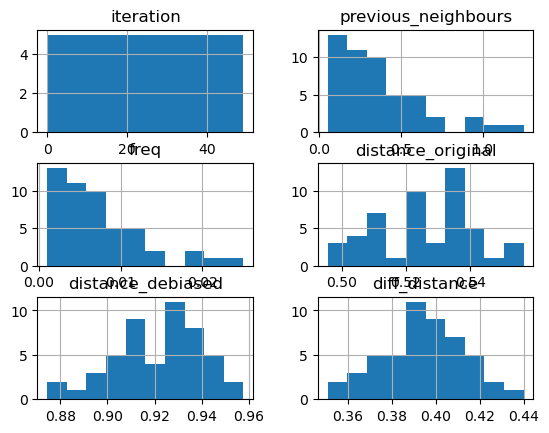

In [96]:
mean_df.hist()


In [111]:
#get quantiles of the mean_df['diff_distance']
q1,_,q3=mean_df['diff_distance'].quantile([0.25,0.5,0.75])
print(q1,q3)

0.38402262174331453 0.4055498757825879


In [100]:
mean_df['diff_distance'].quantile([0.75])


0.75    0.40555
Name: diff_distance, dtype: float64

In [104]:
#create a column to test whether the difference is greater than the 75th quantile or smaller than the 0.25 quantile
mean_df['diff_distance_quantile']=np.where( mean_df['diff_distance']>=q3, 1, 0)
mean_df['diff_distance_quantile']=np.where( mean_df['diff_distance']<=q1, 1, 0)

In [109]:
mean_df


,iteration,previous_neighbours,freq,distance_original,distance_debiased,diff_distance,diff_distance_quantile
0,0,0.30,0.006,0.522074,0.913265,0.391191,0
1,1,1.25,0.025,0.532726,0.935024,0.402299,0
2,2,0.30,0.006,0.544524,0.911931,0.367407,1
3,3,0.15,0.003,0.537783,0.924794,0.387011,0
4,4,0.60,0.012,0.510579,0.896016,0.385437,0
5,5,0.60,0.012,0.530737,0.900553,0.369815,1
6,6,0.20,0.004,0.533320,0.927565,0.394246,0
7,7,0.55,0.011,0.495629,0.908121,0.412493,0
8,8,0.25,0.005,0.506311,0.924999,0.418688,0
9,9,0.25,0.005,0.544003,0.924722,0.380718,1


In [107]:
sum_out_range=mean_df['diff_distance_quantile'].sum()

In [108]:
sum_out_range/50

0.26

In [152]:
model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)


In [144]:
#define a function to get the average distance between the neighbors of a word in embeddings
def get_average_distance_neighbors(word, embeddings):
    neighbors=embeddings.most_similar(word)
    distances=[]
    all_neighbors=[]
    for neighbor in neighbors[:50]:
        distances.append(1-neighbor[1])
        all_neighbors.append(neighbor[0])
    return all_neighbors,np.mean(distances)

In [145]:
#define a function to get the average distances of neighbors to wors in a list
def get_average_distance_neighbors_50(list_words, embeddings):
    averages=[]
    all_neighbors=[]
    for word in list_words:
        neighbors, average = get_average_distance_neighbors(word, embeddings)
        averages.append(average)
        all_neighbors.append(neighbors)
    
    return all_neighbors,np.mean(averages)


In [171]:
neighbors, average = get_average_distance_neighbors_50(
    random_words, model_original)


In [172]:
average

0.5350232318639755

In [126]:
random_words = np.random.choice(vocab_cleaned, size=50)


In [154]:
distances_original, distances_debiased = get_distance_to_neighbors(random_words, neighbors,
                          dict_vec_cleaned, deb_dict_gender)

In [169]:
#get the averge distance of neighbors to the random words (distances_original.keys())

def get_average_cosine_distance_neighbors_50(dict_distances):
    all_similarities=[]
    for value in dict_distances.values():
        similarity_to_key=[]
        for similitudes in value:
            similarity_to_key.append(similitudes[1])
            
        all_similarities.append(np.mean(similarity_to_key))
    return np.mean(all_similarities)

In [173]:
get_average_cosine_distance_neighbors_50(distances_debiased)


0.8883708335257252

In [185]:

np.random.seed(42)
def p_value_sample(embeddings, dict_vec_cleaned, deb_dict_gender, k):

    
    differences=[]
    num_of_samples = min(1000, len(vocab_cleaned) )
    print('num of samples', num_of_samples)
    larger = 0
    for i in range(num_of_samples):
        random_words = np.random.choice(vocab_cleaned, size=k)
        neighbors, s_orig = get_average_distance_neighbors_50(random_words, embeddings)
        _, distances_debiased = get_distance_to_neighbors(random_words, neighbors,
                                                                           dict_vec_cleaned, deb_dict_gender)
        average_deb=get_average_cosine_distance_neighbors_50(distances_debiased)
        
        diff= average_deb -s_orig
        differences.append(diff)

    return differences


In [187]:
values=p_value_sample(model_original, dict_vec_cleaned, deb_dict_gender, 50)

num of samples 1000


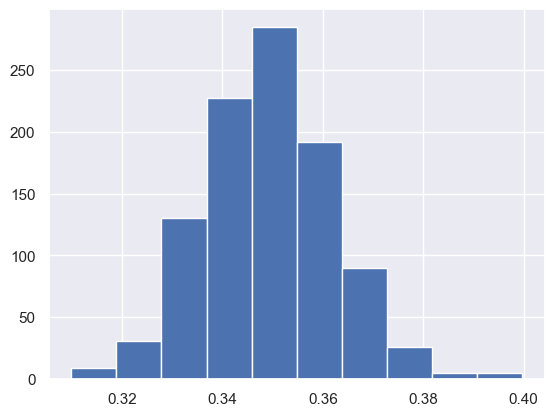

In [192]:
#get the the distribution of the values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.hist(values)
plt.show()


In [194]:
#get the interval of the 95% confidence interval
import numpy as np
np.quantile(values, [0.025, 0.975])



array([0.32555804, 0.37493372])

In [ ]:
w2c = dict()
for item in model.wv.vocab:
    w2c[item]=model.wv.vocab[item].count

In [ ]:
w2cSorted=dict(sorted(w2c.items(), key=lambda x: x[1],reverse=True))